# Networkx and Altair

In [42]:
%matplotlib inline
import numpy as np
import networkx as nx
import altair as alt
import altair_nx as anx

## Create a random network

In [30]:
# np.random.seed(42) # for reproducible results

n_nodes = 30

# Generate a random graph, directed or undirected
G = nx.fast_gnp_random_graph(n = n_nodes, p = 0.25)#, directed = True)

# Give self-loops to half of the nodes
G.add_edges_from([(int(n),int(n)) for n in np.random.default_rng().choice(n_nodes, size = n_nodes // 2, replace = False)])
    # Casting to int since numpy.int64 is not JSON serializable

# Add random attributes to nodes and edges
nx.set_node_attributes(G, {n: dict(importance = np.random.randn(), name = np.random.randint(1000), viable = np.random.choice(['yes', 'no'])) for n in G.nodes})
nx.set_edge_attributes(G, {e: dict(weight = np.random.uniform(1, 10)) for e in G.edges})
    # For a single attribute like this could also just set manually: for e in G.edges(): G.edges[e]['weight'] = np.random.uniform(1, 10)

# Compute node positions (by default, layouts tend to use the 'weight' edge attribute if present)
pos = nx.spring_layout(G)

## Drawing the graph

First, draw it with NetworkX:


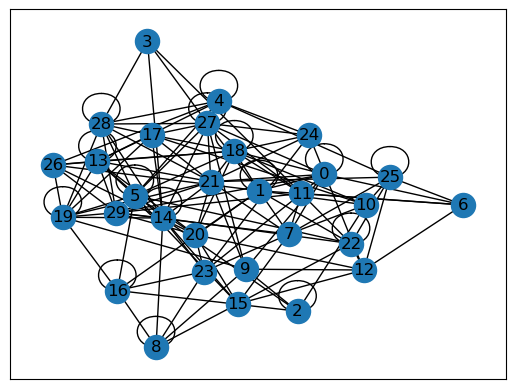

In [31]:
nx.draw_networkx(G, pos)

Next, draw an equivalent non-interactive representation with altair-nx:

In [32]:
anx.draw_networkx(G, pos, node_label = 'node')

alt.LayerChart(...)

Then customise some basic chart properties and add a minimal level of interactivity (tooltips, zoom and panning):

In [33]:
anx.draw_networkx(G, pos,
    node_label = 'node', node_tooltip = ['name', 'importance', 'viable']
).properties(title = 'Interactive Graph').interactive()

alt.LayerChart(...)

Finally, play around with all the arguments (your IDE will likely describe them on hover and show their default values by hovering on the function):

In [38]:
anx.draw_networkx(G, pos,
    node_subset = None, edge_subset = None, show_orphans = True, show_self_loops = True,
    node_size = 'importance', node_outline_width = 1., node_shape = 'viable', node_colour = 'viable', node_cmap = 'viridis', node_alpha = .75,
    node_label = 'node', node_font_size = 15, node_font_colour = 'black', node_tooltip = ['name', 'importance', 'viable'], node_legend = True,
    edge_width = 'weight', edge_colour = 'weight', edge_cmap = 'blues', edge_alpha = .5, edge_tooltip = ['pair', 'weight'], edge_legend = True,
    loop_radius = .04, loop_angle = 90., loop_n_points = 30,
    curved_edges = True, edge_control_points = [(.5,.1)], edge_interpolation = 'basis',
    arrow_width = 2, arrow_length = .1, arrow_length_is_relative = True, arrow_colour = 'black', arrow_cmap = None, arrow_alpha = 1., arrow_legend = False,
    chart_width = 700, chart_height = 500, chart_padding = .05
).properties(title = 'All the options!').interactive()

alt.LayerChart(...)

# Leveraging Altair for deeper interactivity

In [35]:
chart = anx.draw_networkx(G, pos,
    node_size = 200, node_colour = 'viable', node_cmap = 'viridis', node_tooltip = ['importance', 'name', 'viable'],
    edge_width = 'weight'
)

Add some advanced exploration features using Altair:

In [41]:
# Get the node layer
#   The possible layers are [edges, arrows, nodes, labels], in this order,
#   but arrows are present only if G is directed and labels only if node_label is not None.
nodes = chart.layer[-1] # Assuming no labels; fine with both directed and undirected G

# Build a brush
brush = alt.selection_interval(encodings = ['x', 'y'])
colour = alt.Color('viable:N', legend = None)

# Condition nodes based on brush
nodes = nodes.encode(
    fill = alt.condition(brush, colour, alt.value('gray')),
).add_params(
    brush
)

# Create a bar graph to show highlighted nodes
bars = alt.Chart(nodes.data).mark_bar().encode(
    x = alt.X('count()').scale(domain = (0, 20)),
    y = 'viable',
    color = 'viable',
).transform_filter(
    brush
)

# Recombine layers, copy size and axes' ranges, and combine vertically with bars
edges = chart.layer[0] + chart.layer[1] if G.is_directed() else chart.layer[0] # include arrows if present
graph_chart = anx.copy_size_and_axes(chart, edges + nodes) # maintain the original aspect ratio
graph_chart & bars.properties(width = graph_chart.width) # match widths and stack vertically

alt.VConcatChart(...)